In [1]:
# Core
import numpy as np
import pandas as pd

# Tensorflow / ML
import tensorflow as tf
from tensorflow.python.keras import backend as K

# Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl

# Utility
import time

In [2]:
# Configure TF GPU growth
import kepler_sieve
from tf_utils import gpu_grow_memory
gpu_grow_memory(verbose=True)

Found 4 GPUs.  Setting memory growth = True.


In [3]:
# MSE Imports
from asteroid_element import load_ast_elt
from candidate_element import asteroid_elts, random_elts, elts_add_mixture_params, elts_add_H
from random_elements import best_random_elts, make_ztf_ast
from ztf_ast import load_ztf_nearest_ast, calc_hit_freq
from ztf_element import load_ztf_batch, make_ztf_batch, ztf_score_by_elt, ztf_elt_summary
from asteroid_model import AsteroidPosition, AsteroidDirection, make_model_ast_pos
from asteroid_search_layers import CandidateElements, TrajectoryScore
from asteroid_search_model import AsteroidSearchModel, make_opt_adam
from asteroid_search_report import traj_diff
from nearest_asteroid import nearest_ast_elt_cart, nearest_ast_elt_cov, elt_q_norm
from element_eda import score_by_elt
from asteroid_dataframe import calc_ast_data, spline_ast_vec_df
from astro_utils import deg2dist, dist2deg, dist2sec

In [4]:
# Aliases
keras = tf.keras

# Constants
dtype = tf.float32
dtype_np = np.float32
space_dims = 3

In [5]:
# Set plot style variables
mpl.rcParams['figure.figsize'] = [16.0, 10.0]
mpl.rcParams['font.size'] = 16

## Load ZTF Data and Batch of Orbital Elements

In [6]:
# Load orbital elements for known asteroids
ast_elt = load_ast_elt()

# Number of asteroids
N_ast = ast_elt.shape[0]

In [7]:
# Parameters to build random orbital elements and ztf_ast
random_seed = 0
known_ast = True
batch_size_init = 1024
batch_size = 64
thresh_deg = 2.0

In [8]:
# Load ztf nearest asteroid data for known asteroids
ztf_ast = make_ztf_ast(known_ast=known_ast)

In [9]:
# Review ztf_ast
ztf_ast

,ztf_id,ObjectID,CandidateID,TimeStampID,mjd,ra,dec,ux,uy,uz,mag_app,asteroid_prob,nearest_ast_num,nearest_ast_dist,ast_ra,ast_dec,ast_ux,ast_uy,ast_uz,is_hit
602,602,b'ZTF18acqvjbw',689314713015015008,16951,58443.314711,63.025354,17.655906,0.432230,0.899796,-0.059531,18.519199,1.000000,135355,3.663691e-06,63.025567,17.655961,0.432226,0.899798,-0.059531,True
649,649,b'ZTF18acrcadh',693308213515015017,17096,58447.308218,113.354357,33.962194,-0.328791,0.920837,0.209659,18.055201,1.000000,29076,8.997226e-07,113.354324,33.962150,-0.328790,0.920837,0.209658,True
811,811,b'ZTF18abwawbk',621435901715015019,9621,58375.435903,32.348343,11.149056,0.828867,0.558563,-0.031414,19.707199,1.000000,101787,2.084178e-06,32.348465,11.149059,0.828866,0.558565,-0.031414,True
833,833,b'ZTF18acurwxa',707509454415015012,18339,58461.509456,103.310341,27.540611,-0.204137,0.975586,0.080995,19.427401,1.000000,138763,4.068908e-06,103.310581,27.540515,-0.204141,0.975585,0.080994,True
890,890,b'ZTF18acuiphp',707257536115015009,18272,58461.257535,48.496514,22.452973,0.612431,0.786949,0.075091,19.038000,0.976392,105289,3.491132e-06,48.496726,22.453012,0.612428,0.786952,0.075091,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5697829,5697829,b'ZTF20aarepii',1151522393415015017,97090,58905.522396,236.892710,-2.341055,-0.545753,-0.784135,0.295442,15.089800,1.000000,727,2.473898e-06,236.892569,-2.341034,-0.545755,-0.784134,0.295442,True
5697832,5697832,b'ZTF20aareowa',1151522390315015003,97090,58905.522396,237.654792,-5.909325,-0.532176,-0.811960,0.239813,15.717300,1.000000,625,2.355026e-06,237.654657,-5.909328,-0.532178,-0.811958,0.239813,True
5697833,5697833,b'ZTF20aareowm',1151521944715015006,97089,58905.521944,236.239354,-9.304550,-0.548413,-0.817041,0.178007,15.695800,1.000000,464,2.205903e-06,236.239228,-9.304526,-0.548415,-0.817040,0.178007,True
5697838,5697838,b'ZTF20aareowf',1151521946215015005,97089,58905.521944,234.674482,-7.771349,-0.572910,-0.795468,0.197496,16.917900,1.000000,2879,4.163074e-06,234.674242,-7.771368,-0.572914,-0.795466,0.197494,True


In [10]:
# Best random elements
elts = best_random_elts(random_seed=random_seed, known_ast=known_ast, 
                        batch_size_init=batch_size_init, batch_size=batch_size, thresh_deg=thresh_deg)

In [11]:
# Review best random elements
elts

,element_id,a,e,f,inc,Omega,omega,epoch,num_obs,score,t_score
0,0,3.064054,0.121235,-1.291546,0.068009,0.662207,0.935398,58600.0,12711,998.002460,8.852007
1,1,2.771068,0.151421,-0.531263,0.068958,1.364763,6.111150,58600.0,11901,886.807208,8.129007
2,2,3.172947,0.095819,1.903106,0.035792,3.984825,0.687484,58600.0,12572,781.406566,6.969071
3,3,2.697356,0.098236,0.132486,0.025427,1.610715,5.259525,58600.0,9835,767.421579,7.738322
4,4,3.113809,0.257043,2.596678,0.090822,0.106255,4.320585,58600.0,9129,697.797101,7.303273
...,...,...,...,...,...,...,...,...,...,...,...
59,59,1.890665,0.083441,3.132056,0.035993,0.656159,3.255417,58600.0,9064,280.408751,2.945314
60,60,3.168699,0.088259,0.853523,0.052655,5.188591,0.902693,58600.0,10197,280.102124,2.773832
61,61,2.255124,0.055124,-1.131100,0.065725,4.743550,1.882832,58600.0,6700,279.483345,3.414432
62,62,2.325415,0.176758,-0.619556,0.046713,3.318604,2.235867,58600.0,4532,277.344008,4.119778


## Batches of ZTF Data Near Initial Candidate Elements

In [12]:
# Arguments to make_ztf_batch
near_ast = False
regenerate = False

In [13]:
# Load perturbed element batch
ztf_elt = load_ztf_batch(elts=elts, ztf=ztf_ast, thresh_deg=thresh_deg, near_ast=near_ast, regenerate=regenerate)

In [14]:
ztf_elt

,ztf_id,element_id,ObjectID,CandidateID,TimeStampID,mjd,ra,dec,ux,uy,...,elt_ux,elt_uy,elt_uz,elt_r,s,s_sec,z,v,is_hit,is_match
0,357652,0,b'ZTF19abjggig',938492372315015003,1268,58692.492373,53.778435,17.745455,0.562794,0.826188,...,0.554305,0.832313,-0.001318,3.030342,0.026805,5529.148243,0.999641,0.589752,False,False
1,358253,0,b'ZTF19abjgfhg',938492373915015003,1268,58692.492373,53.995882,19.505049,0.554108,0.832439,...,0.554305,0.832313,-0.001318,3.030342,0.004338,894.747682,0.999991,0.015445,False,False
2,359127,0,b'ZTF19abjgfhd',938492373915015019,1268,58692.492373,53.303148,19.154581,0.564497,0.825435,...,0.554305,0.832313,-0.001318,3.030342,0.012343,2545.891323,0.999924,0.125041,False,False
3,359244,0,b'ZTF19abjgfqh',938492373315015008,1268,58692.492373,54.457412,20.235852,0.545428,0.838047,...,0.554305,0.832313,-0.001318,3.030342,0.018328,3780.523027,0.999832,0.275722,False,False
4,359275,0,b'ZTF19abjgfjl',938492371615015001,1268,58692.492373,55.224952,18.713324,0.540204,0.841398,...,0.554305,0.832313,-0.001318,3.030342,0.021711,4478.268990,0.999764,0.386885,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512300,5682027,63,b'ZTF20aarbsoy',1151130435015015008,39108,58905.130440,46.250023,14.103319,0.670669,0.739706,...,0.660978,0.749074,-0.044681,2.592171,0.017045,3515.894844,0.999855,0.238474,False,False
512301,5682059,63,b'ZTF20aarbsvt',1151130433215015003,39108,58905.130440,46.974922,12.957800,0.664943,0.742845,...,0.660978,0.749074,-0.044681,2.592171,0.033797,6971.539164,0.999429,0.937551,False,False
512302,5682122,63,b'ZTF20aarbsrh',1151130435215015007,39108,58905.130440,44.917822,15.212759,0.683306,0.729504,...,0.660978,0.749074,-0.044681,2.592171,0.033002,6807.415135,0.999455,0.893931,False,False
512303,5682133,63,b'ZTF20aarbsrx',1151130434815015006,39108,58905.130440,47.131113,15.156325,0.656659,0.753044,...,0.660978,0.749074,-0.044681,2.592171,0.006666,1374.963549,0.999978,0.036472,False,False


In [15]:
# Score by element
score_by_elt = ztf_score_by_elt(ztf_elt)

In [16]:
# Mixture parameters
num_hits: int = 10
R_deg: float = 0.5

In [17]:
# Add mixture parameters to candidate elements
elts_add_mixture_params(elts=elts, num_hits=num_hits, thresh_deg=thresh_deg, R_deg=R_deg)

In [18]:
# Add brightness parameter H
elts_add_H(elts=elts)

In [19]:
# Summarize the ztf element batch: perturbed asteroids
ztf_elt_summary(ztf_elt, score_by_elt, 'Random Elements')

ZTF Element Dataframe Random Elements:
                  Total     (Per Batch)
Observations   :   512305   (     8005)

Summarize score = sum(-1.0 - log(v)) by batch.  (Mean=0, Variance=num_obs)
Mean score     :     442.59
Sqrt(batch_obs):      89.47
Mean t_score   :       5.11


In [20]:
# Review random elements
elts

,element_id,a,e,f,inc,Omega,omega,epoch,num_obs,score,t_score,num_hits,R,thresh_s,H,sigma_mag
0,0,3.064054,0.121235,-1.291546,0.068009,0.662207,0.935398,58600.0,12711,998.002460,8.852007,10,0.008727,0.034905,16.5,4.0
1,1,2.771068,0.151421,-0.531263,0.068958,1.364763,6.111150,58600.0,11901,886.807208,8.129007,10,0.008727,0.034905,16.5,4.0
2,2,3.172947,0.095819,1.903106,0.035792,3.984825,0.687484,58600.0,12572,781.406566,6.969071,10,0.008727,0.034905,16.5,4.0
3,3,2.697356,0.098236,0.132486,0.025427,1.610715,5.259525,58600.0,9835,767.421579,7.738322,10,0.008727,0.034905,16.5,4.0
4,4,3.113809,0.257043,2.596678,0.090822,0.106255,4.320585,58600.0,9129,697.797101,7.303273,10,0.008727,0.034905,16.5,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,59,1.890665,0.083441,3.132056,0.035993,0.656159,3.255417,58600.0,9064,280.408751,2.945314,10,0.008727,0.034905,16.5,4.0
60,60,3.168699,0.088259,0.853523,0.052655,5.188591,0.902693,58600.0,10197,280.102124,2.773832,10,0.008727,0.034905,16.5,4.0
61,61,2.255124,0.055124,-1.131100,0.065725,4.743550,1.882832,58600.0,6700,279.483345,3.414432,10,0.008727,0.034905,16.5,4.0
62,62,2.325415,0.176758,-0.619556,0.046713,3.318604,2.235867,58600.0,4532,277.344008,4.119778,10,0.008727,0.034905,16.5,4.0


## Build Asteroid Search Model

In [21]:
# Observatory for ZTF data is Palomar Mountain
site_name = 'palomar'

In [22]:
# Training parameters
learning_rate = 2.0**-12
clipnorm = 1.0

In [23]:
# Build asteroid search model
model = AsteroidSearchModel(
                elts=elts, ztf_elt=ztf_elt, 
                site_name=site_name, thresh_deg=thresh_deg, 
                learning_rate=learning_rate, clipnorm=clipnorm,
                name='model')

In [24]:
# Report before training starts
model.report()


Good elements (hits > 10):   0.00

         \  log_like :  hits  :    R_sec : thresh_sec
Mean Good:      nan  :    nan :      nan :      nan
Mean     :     1.02  :   0.00 :  1793.94 :  7200.00
Median   :     0.97  :   0.00 :  1792.82 :  7200.00
GeoMean  :     1.16  :   0.00 :  1793.94 :  7200.99
Std      :     0.50  :   0.00 :     3.86 :     0.00
Min      :     0.26  :   0.00 :  1792.82 :  7200.00
Max      :     2.71  :   0.00 :  1807.21 :  7200.00
Trained for 0 batches over 0 epochs and 0 episodes.


/home/michael/anaconda3/envs/kepler/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/michael/anaconda3/envs/kepler/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


## Automated Training with Sieve Method


********************************************************************************
Round 1: 2000 batches @ LR 2^-12 with frozen elements.
********************************************************************************

Training episode 0: Epoch    0, Batch      0
effective_learning_rate=2.441e-04, training_time 0 sec.
Train on 6400 samples
Epoch 1/5
6400/6400 [==============================] - 5s 744us/sample - loss: -59148.7227
Epoch 2/5
6400/6400 [==============================] - 3s 499us/sample - loss: -81743.0608
Epoch 3/5
6400/6400 [==============================] - 3s 504us/sample - loss: -113267.7724
Epoch 4/5
6400/6400 [==============================] - 3s 498us/sample - loss: -156188.6552
Epoch 5/5
6400/6400 [==============================] - 3s 493us/sample - loss: -206597.3388
                    \  All Elts : Good Elts (0)
Geom Mean Resolution:    947.07 :      nan arc seconds
Geom Mean Threshold :   7200.00 :      nan arc seconds
Mean Log Likelihood :      4.74 :      nan

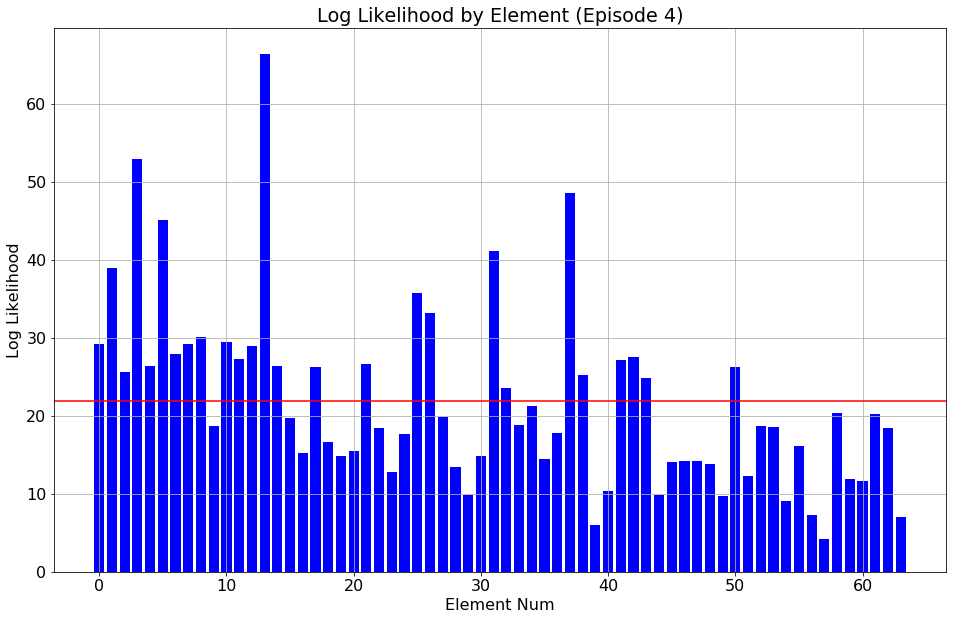

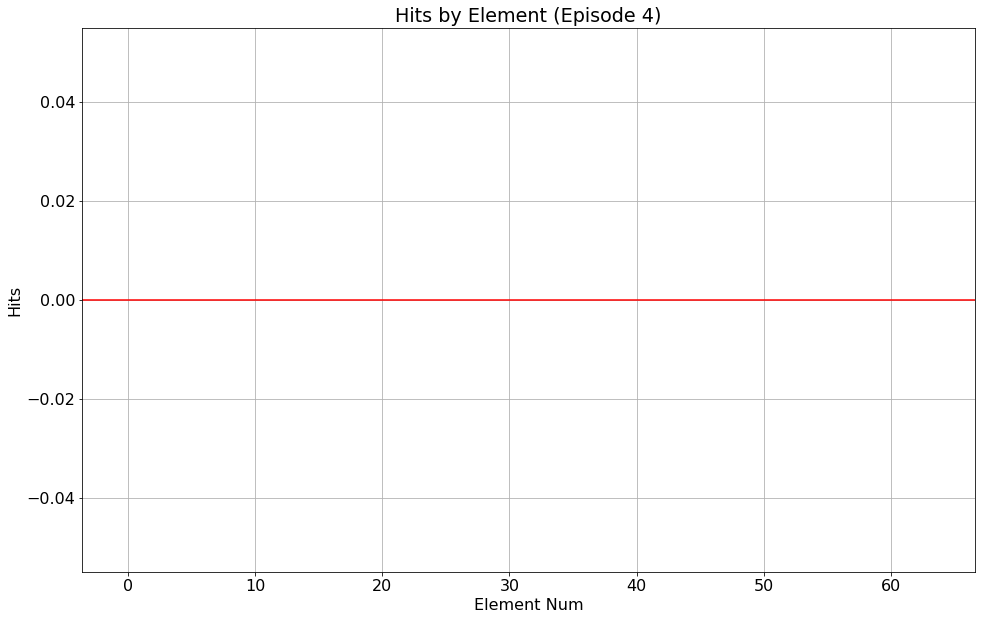


********************************************************************************
Round 2: 2500 batches @ LR 2^-15 with live elements.
********************************************************************************
Applying learning_rate 3.05e-05 (2.0^-15.0) for adaptive training.

Training episode 4: Epoch   20, Batch   2000
effective_learning_rate=2.441e-04, training_time 73 sec.
Train on 6400 samples
Epoch 21/25
6400/6400 [==============================] - 6s 921us/sample - loss: -2586366.7300
Epoch 22/25
6400/6400 [==============================] - 4s 593us/sample - loss: -3145150.1250
Epoch 23/25
6400/6400 [==============================] - 4s 604us/sample - loss: -3420586.8250
Epoch 24/25
6400/6400 [==============================] - 4s 596us/sample - loss: -3629373.3625
Epoch 25/25
6400/6400 [==============================] - 4s 593us/sample - loss: -3821952.0500
                    \  All Elts : Good Elts (0)
Geom Mean Resolution:   1221.25 :      nan arc seconds
Geom Mean Thre

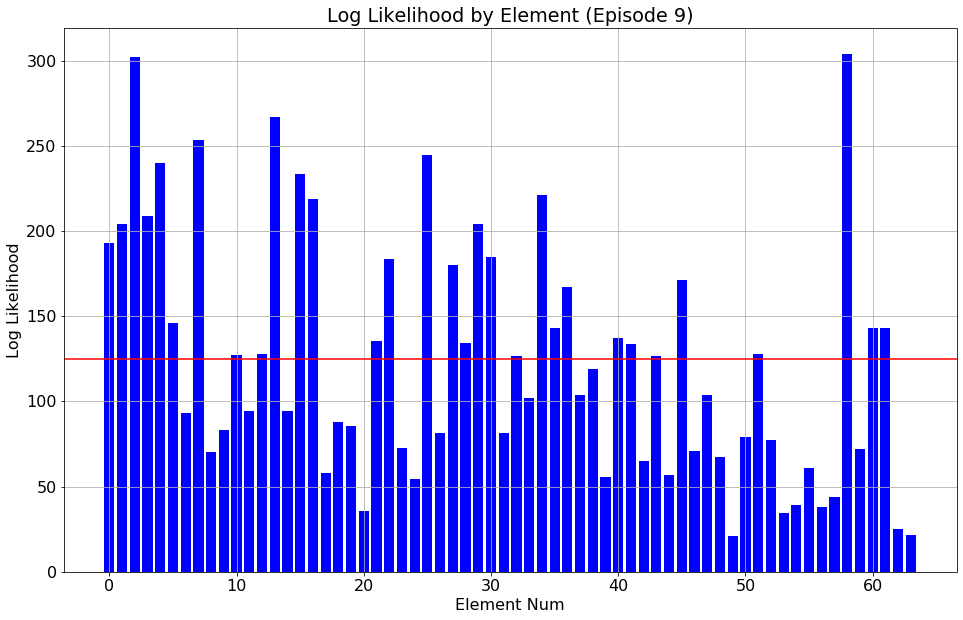

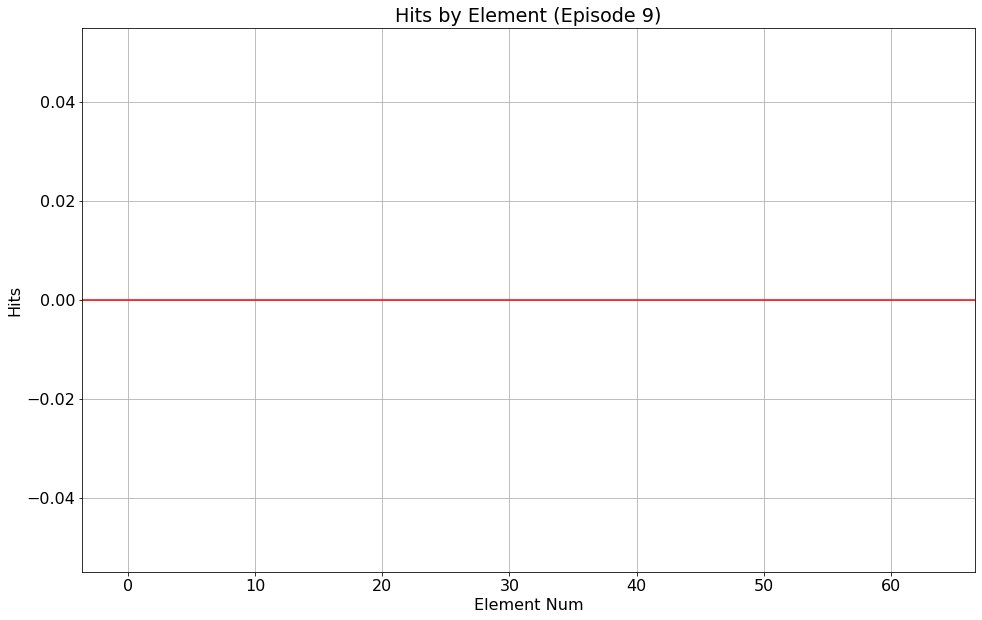


********************************************************************************
Round 3: 500 batches @ LR 2^-12 with frozen elements; thresh_sec_max = 2400.0
********************************************************************************

Training episode 9: Epoch   45, Batch   4500
effective_learning_rate=2.891e-05, training_time 179 sec.
Train on 6400 samples
Epoch 46/50
6400/6400 [==============================] - 5s 709us/sample - loss: -5935913.8450
Epoch 47/50
6400/6400 [==============================] - 3s 478us/sample - loss: -8719383.3000
Epoch 48/50
6400/6400 [==============================] - 3s 487us/sample - loss: -10893215.4600
Epoch 49/50
6400/6400 [==============================] - 3s 476us/sample - loss: -13450264.9800
Epoch 50/50
6400/6400 [==============================] - 3s 473us/sample - loss: -16801911.4400
Adjusted element weight down on 2 candidate elements. Mean weight = 9.84e-01
                    \  All Elts : Good Elts (0)
Geom Mean Resolution:    888.3

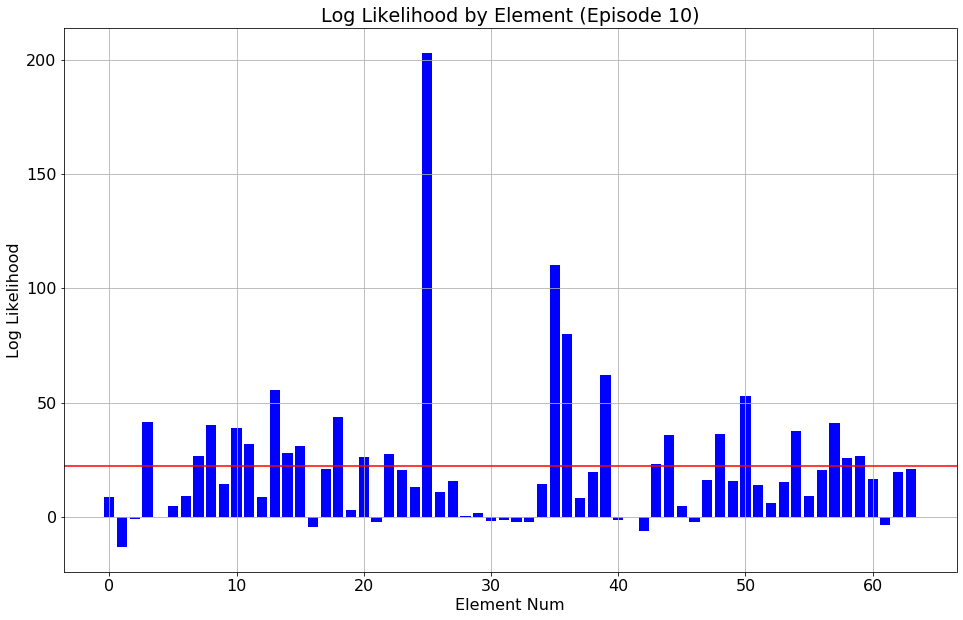

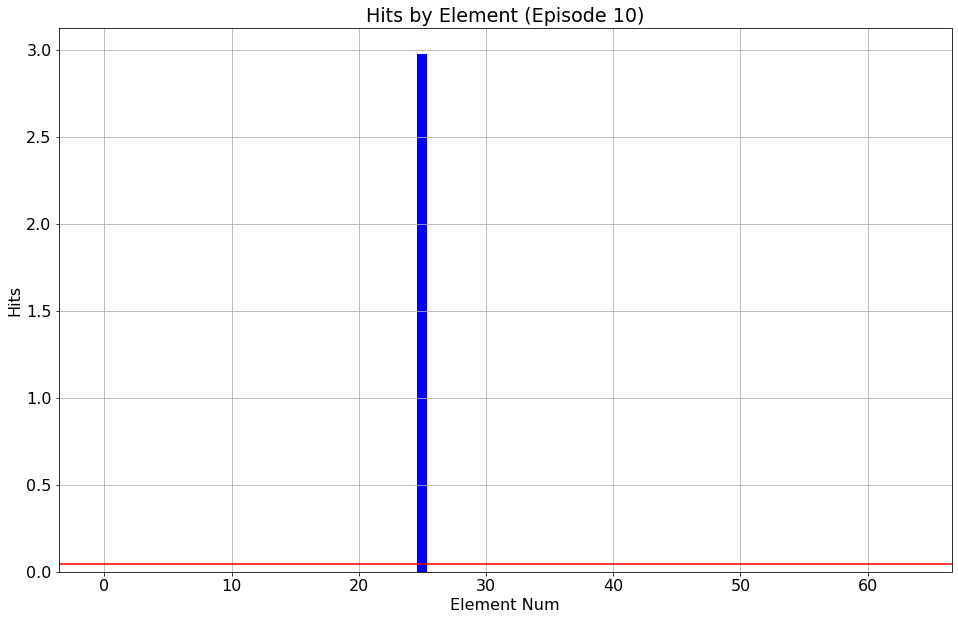


********************************************************************************
Round 4: 2500 batches @ LR 2^-15 with live elements.
********************************************************************************
Applying learning_rate 3.05e-05 (2.0^-15.0) for adaptive training.

Training episode 10: Epoch   50, Batch   5000
effective_learning_rate=2.403e-04, training_time 198 sec.
Train on 6400 samples
Epoch 51/55
6400/6400 [==============================] - 6s 871us/sample - loss: -18894203.5200
Epoch 52/55
6400/6400 [==============================] - 4s 579us/sample - loss: -20428090.1800
Epoch 53/55
6400/6400 [==============================] - 4s 576us/sample - loss: -21376506.6000
Epoch 54/55
6400/6400 [==============================] - 4s 581us/sample - loss: -22145891.2000
Epoch 55/55
6400/6400 [==============================] - 4s 573us/sample - loss: -22989348.3600
Adjusted element weight down on 6 candidate elements. Mean weight = 9.06e-01
                    \  All Elts :

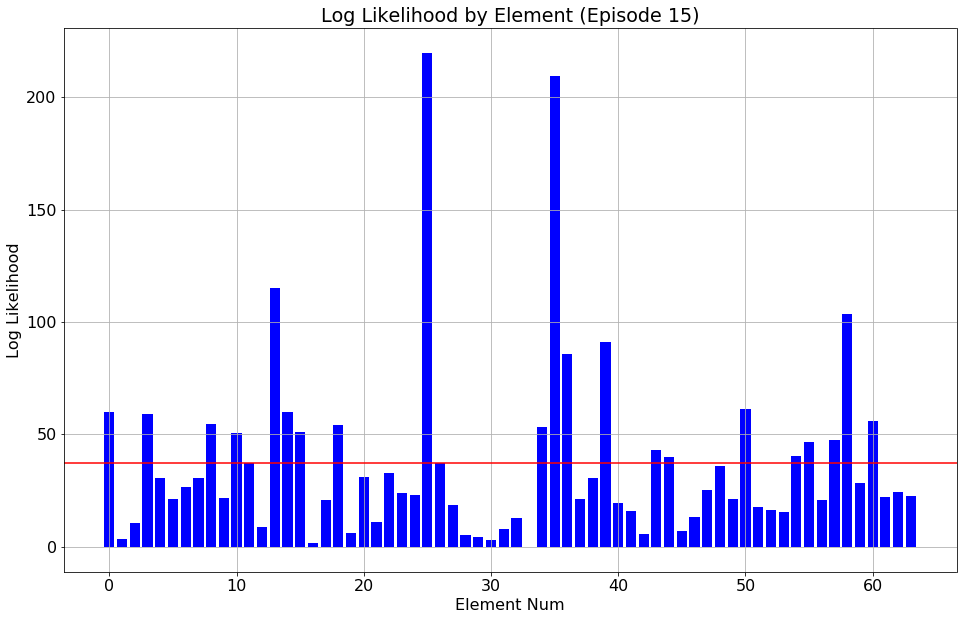

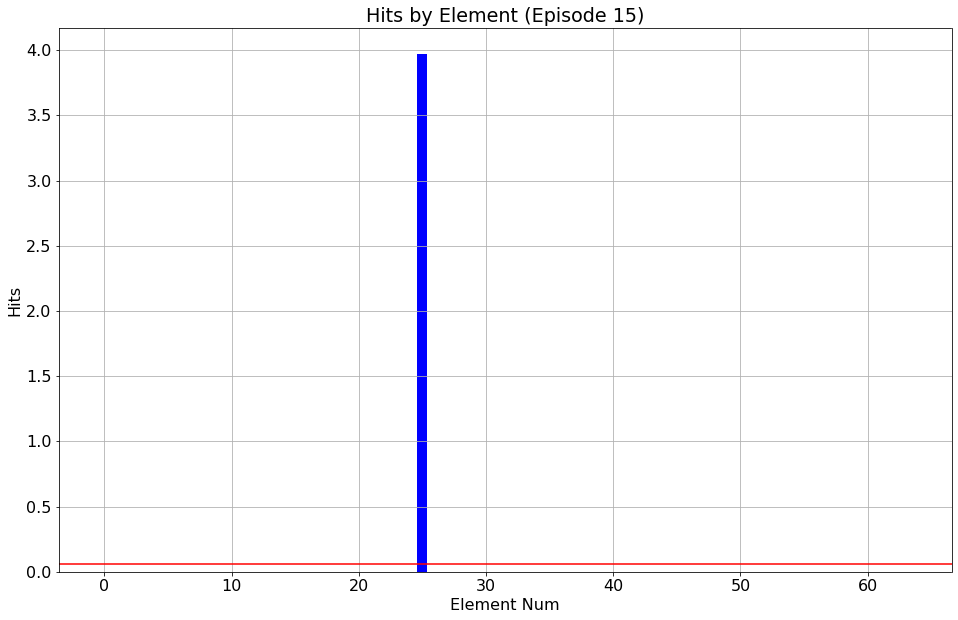


********************************************************************************
Round 5: 500 batches @ LR 2^-12 with frozen elements; thresh_sec_max = 1600.0
********************************************************************************

Training episode 15: Epoch   75, Batch   7500
effective_learning_rate=1.918e-05, training_time 301 sec.
Train on 6400 samples
Epoch 76/80
6400/6400 [==============================] - 5s 761us/sample - loss: -35814219.1800
Epoch 77/80
6400/6400 [==============================] - 3s 520us/sample - loss: -44014320.6400
Epoch 78/80
6400/6400 [==============================] - 3s 519us/sample - loss: -54305367.2000
Epoch 79/80
6400/6400 [==============================] - 3s 516us/sample - loss: -69290953.2800
Epoch 80/80
6400/6400 [==============================] - 3s 520us/sample - loss: -92156149.2800
Adjusted element weight down on 7 candidate elements. Mean weight = 9.34e-01
                    \  All Elts : Good Elts (0)
Geom Mean Resolution:    58

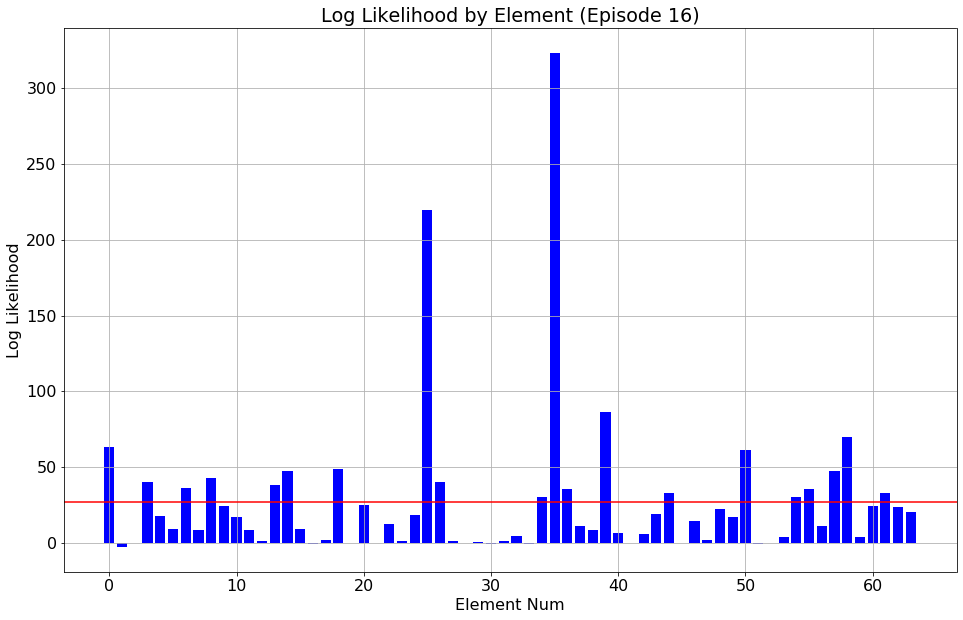

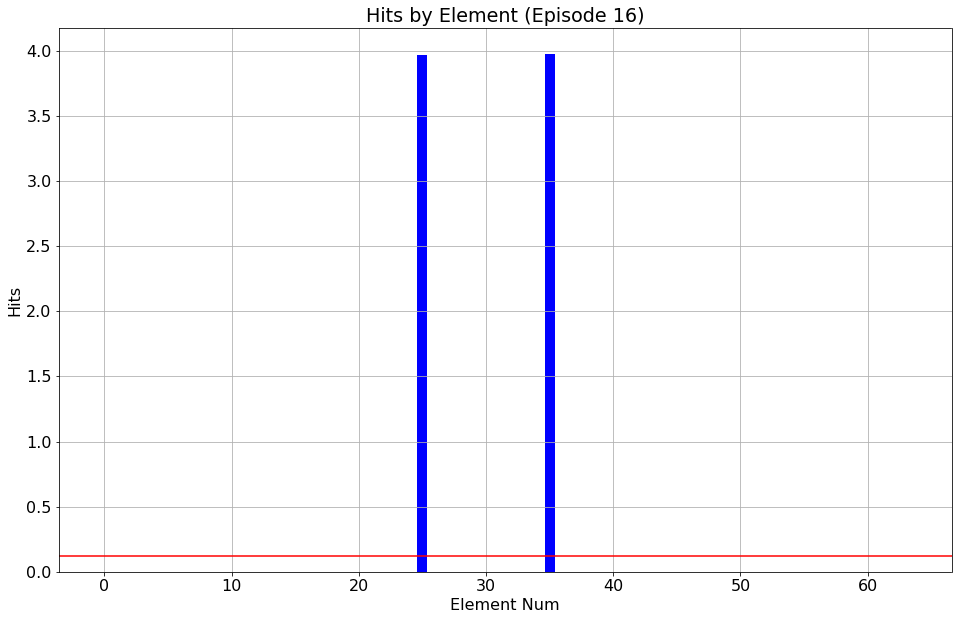


********************************************************************************
Round 6: 2500 batches @ LR 2^-15 with live elements.
********************************************************************************
Applying learning_rate 3.05e-05 (2.0^-15.0) for adaptive training.

Training episode 16: Epoch   80, Batch   8000
effective_learning_rate=2.279e-04, training_time 322 sec.
Train on 6400 samples
Epoch 81/85
6400/6400 [==============================] - 6s 937us/sample - loss: -54199637.5800
Epoch 82/85
6400/6400 [==============================] - 4s 614us/sample - loss: -63172564.0400
Epoch 83/85
6400/6400 [==============================] - 4s 605us/sample - loss: -65181459.7200
Epoch 84/85
6400/6400 [==============================] - 4s 612us/sample - loss: -67320895.1200
Epoch 85/85
6400/6400 [==============================] - 4s 610us/sample - loss: -69794006.0800
Adjusted element weight down on 5 candidate elements. Mean weight = 6.02e-01
                    \  All Elts :

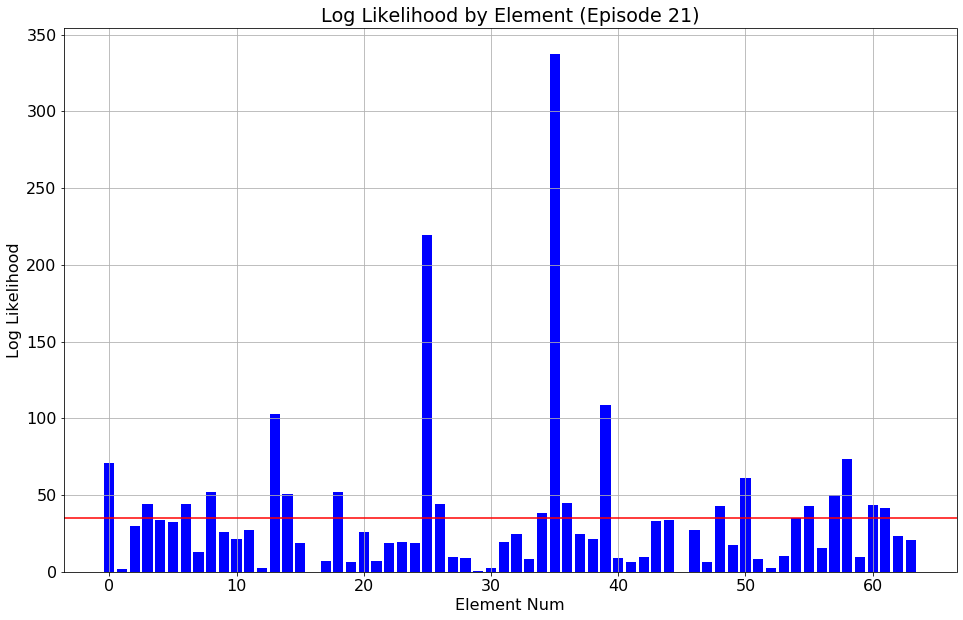

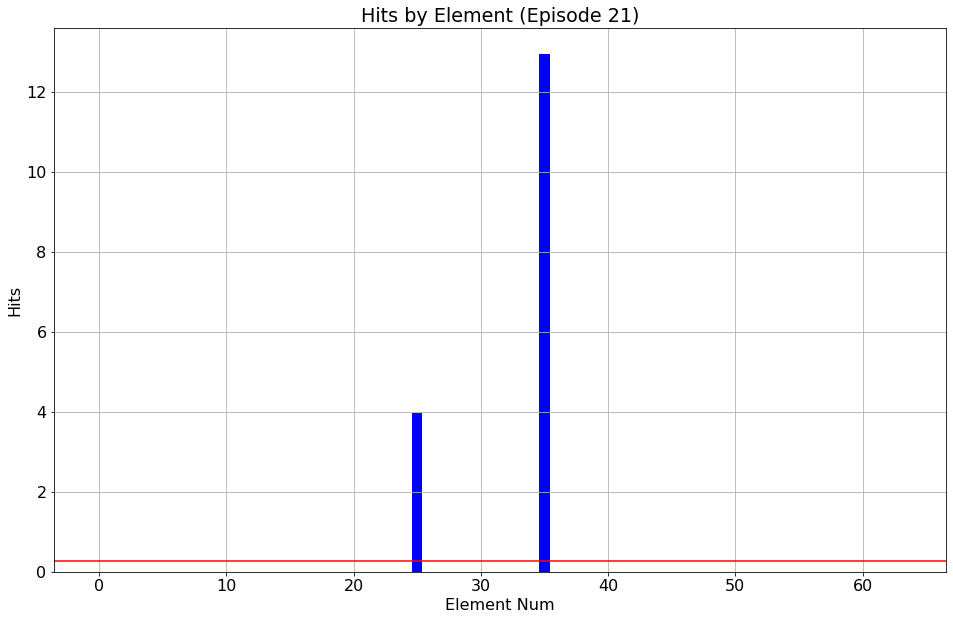


********************************************************************************
Round 7: 500 batches @ LR 2^-12 with frozen elements; thresh_sec_max = 800.0
********************************************************************************

Training episode 21: Epoch  105, Batch  10500
effective_learning_rate=1.058e-05, training_time 432 sec.
Train on 6400 samples
Epoch 106/110
6400/6400 [==============================] - 5s 844us/sample - loss: -94990335.2800
Epoch 107/110
6400/6400 [==============================] - 3s 543us/sample - loss: -115161793.2800
Epoch 108/110
6400/6400 [==============================] - 3s 543us/sample - loss: -135439320.0800
Epoch 109/110
6400/6400 [==============================] - 3s 546us/sample - loss: -160754567.8400
Epoch 110/110
6400/6400 [==============================] - 4s 550us/sample - loss: -199449698.4000
Adjusted element weight down on 8 candidate elements. Mean weight = 8.87e-01
                    \  All Elts : Good Elts (1)
Geom Mean Reso

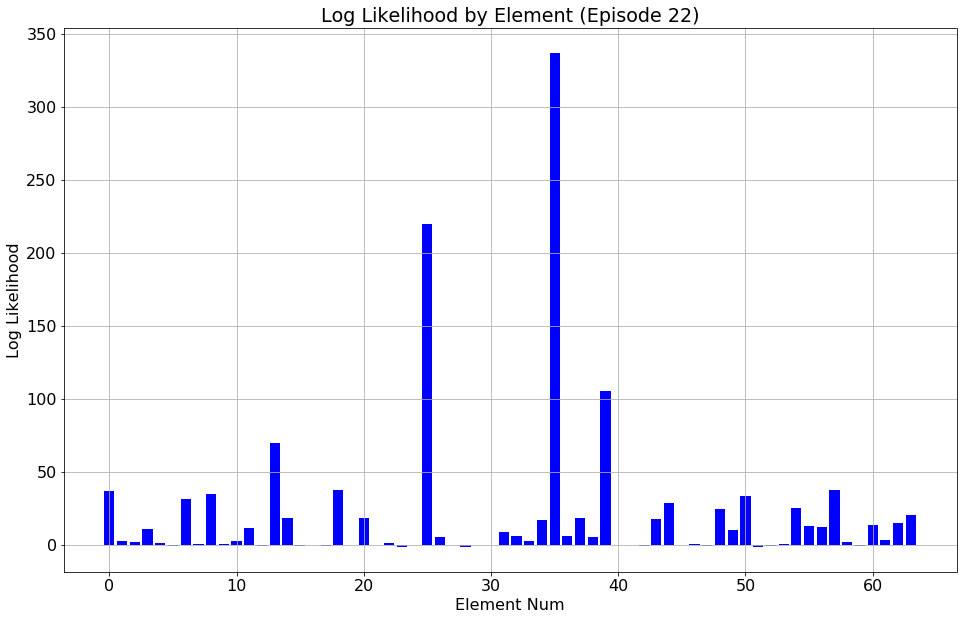

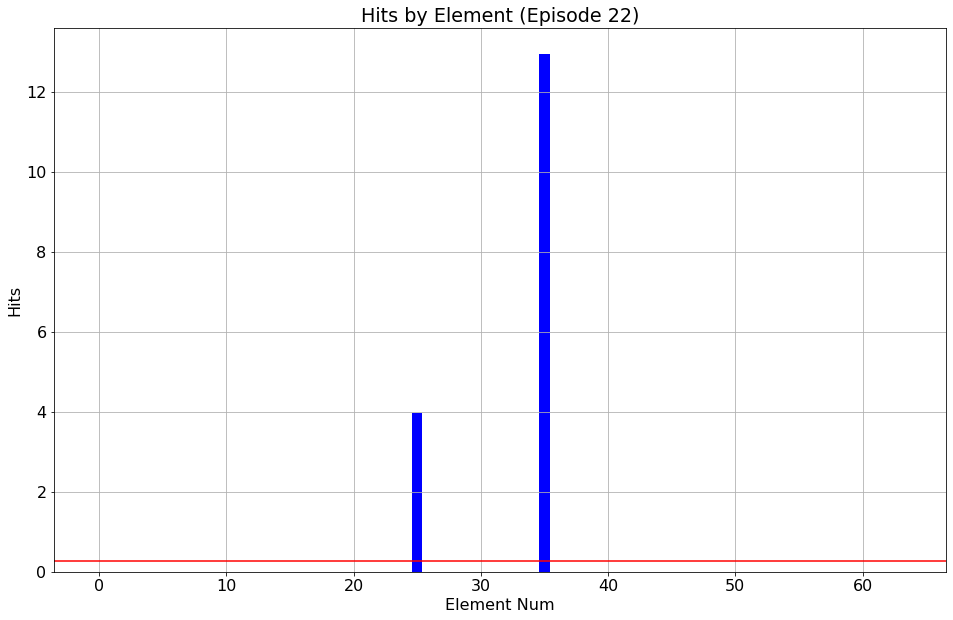


********************************************************************************
Round 8: 2500 batches @ LR 2^-15 with live elements.
********************************************************************************
Applying learning_rate 3.05e-05 (2.0^-15.0) for adaptive training.

Training episode 22: Epoch  110, Batch  11000
effective_learning_rate=2.165e-04, training_time 454 sec.
Train on 6400 samples
Epoch 111/115
6400/6400 [==============================] - 6s 950us/sample - loss: -65128957.7450
Epoch 112/115
6400/6400 [==============================] - 4s 641us/sample - loss: -70903252.9600
Epoch 113/115
6400/6400 [==============================] - 4s 654us/sample - loss: -73284036.9600
Epoch 114/115
6400/6400 [==============================] - 4s 646us/sample - loss: -75680918.1600
Epoch 115/115
6400/6400 [==============================] - 4s 643us/sample - loss: -77789439.2800
Adjusted element weight down on 8 candidate elements. Mean weight = 3.44e-01
                    \  

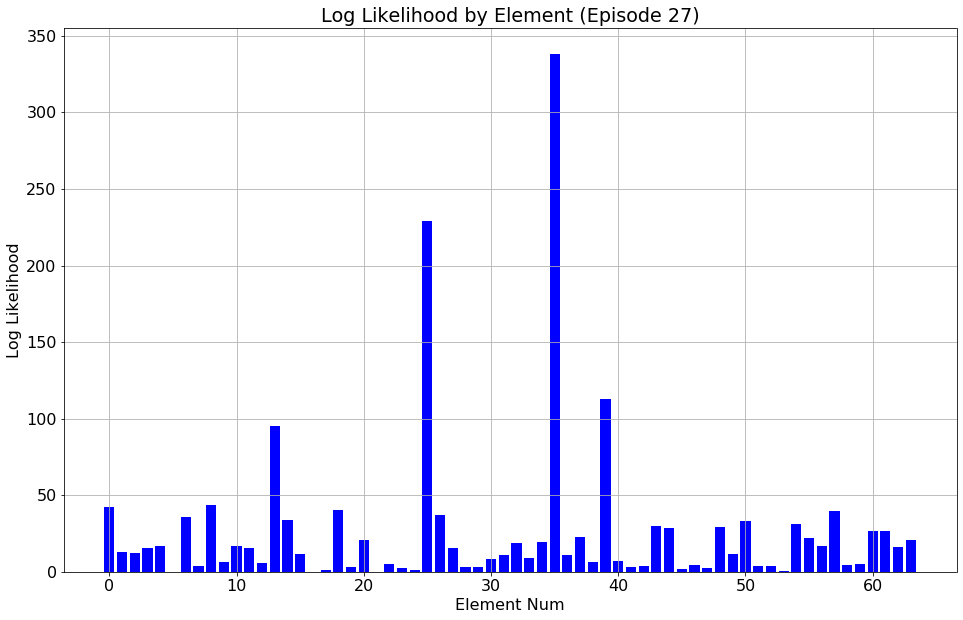

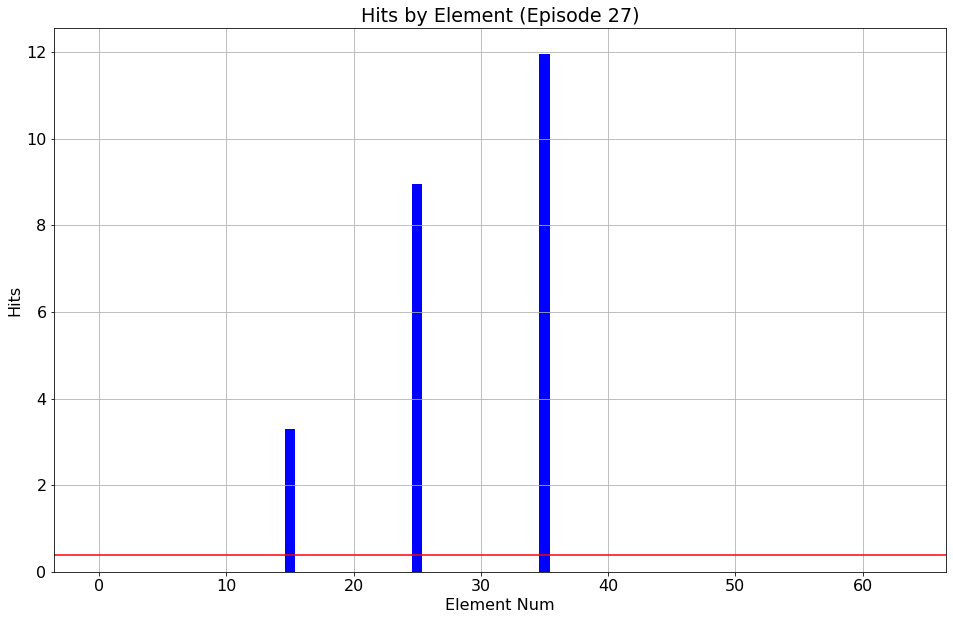


********************************************************************************
Round 9: 500 batches @ LR 2^-12 with frozen elements; thresh_sec_max = 400.0
********************************************************************************

Training episode 27: Epoch  135, Batch  13500
effective_learning_rate=6.711e-06, training_time 569 sec.
Train on 6400 samples
Epoch 136/140
6400/6400 [==============================] - 5s 830us/sample - loss: -135361538.8800
Epoch 137/140
6400/6400 [==============================] - 4s 573us/sample - loss: -161287108.8000
Epoch 138/140
6400/6400 [==============================] - 4s 577us/sample - loss: -186427762.0800
Epoch 139/140
6400/6400 [==============================] - 4s 577us/sample - loss: -213438732.1600
Epoch 140/140
6400/6400 [==============================] - 4s 582us/sample - loss: -238843152.9600
Adjusted element weight down on 17 candidate elements. Mean weight = 7.85e-01
                    \  All Elts : Good Elts (1)
Geom Mean Re

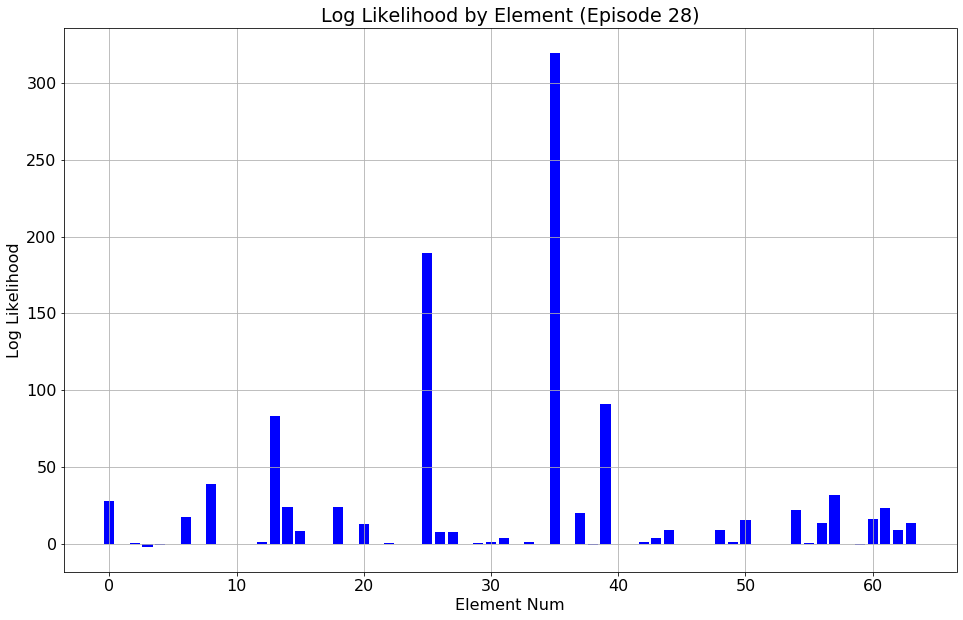

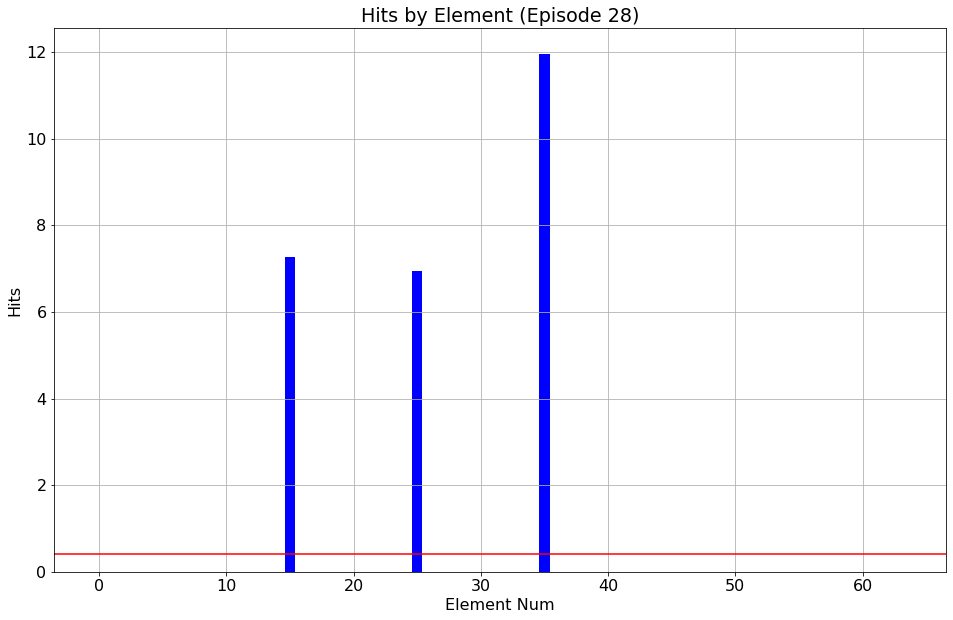


********************************************************************************
Round 10: 2500 batches @ LR 2^-15 with live elements.
********************************************************************************
Applying learning_rate 3.05e-05 (2.0^-15.0) for adaptive training.

Training episode 28: Epoch  140, Batch  14000
effective_learning_rate=1.917e-04, training_time 591 sec.
Train on 6400 samples
Epoch 141/145
6400/6400 [==============================] - 6s 992us/sample - loss: -67385603.5600
Epoch 142/145
6400/6400 [==============================] - 4s 691us/sample - loss: -77346583.7600
Epoch 143/145
6400/6400 [==============================] - 4s 685us/sample - loss: -78742913.4400
Epoch 144/145
6400/6400 [==============================] - 4s 673us/sample - loss: -80492667.9200
Epoch 145/145
6400/6400 [==============================] - 4s 675us/sample - loss: -83655896.0000
Adjusted element weight down on 16 candidate elements. Mean weight = 2.09e-01
                    \

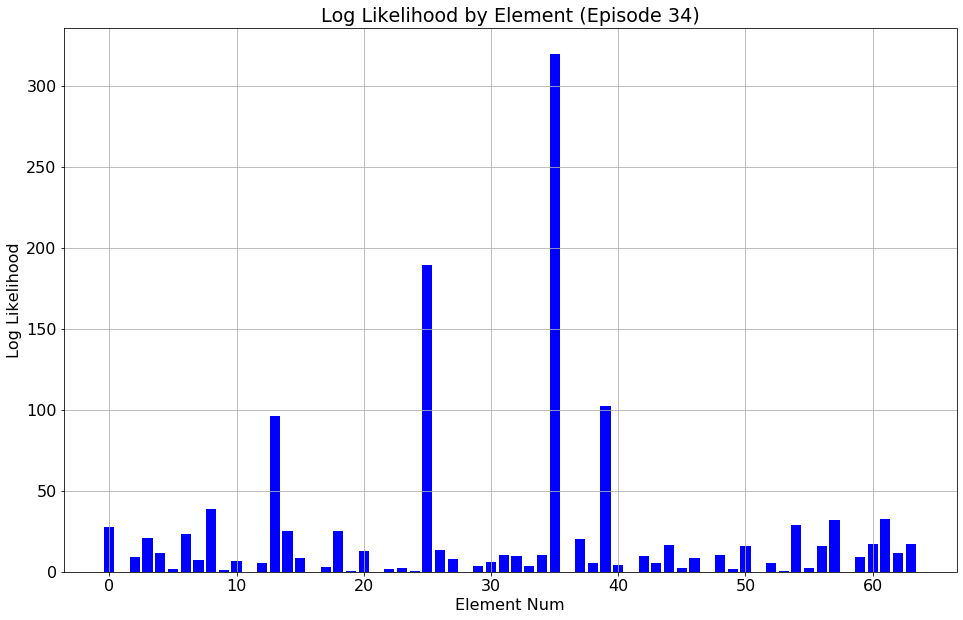

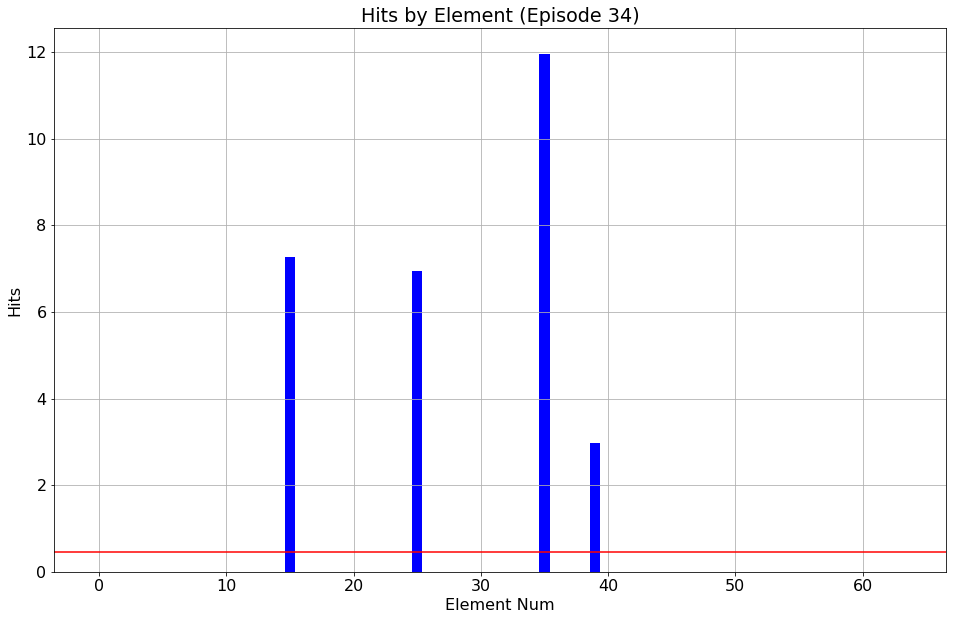

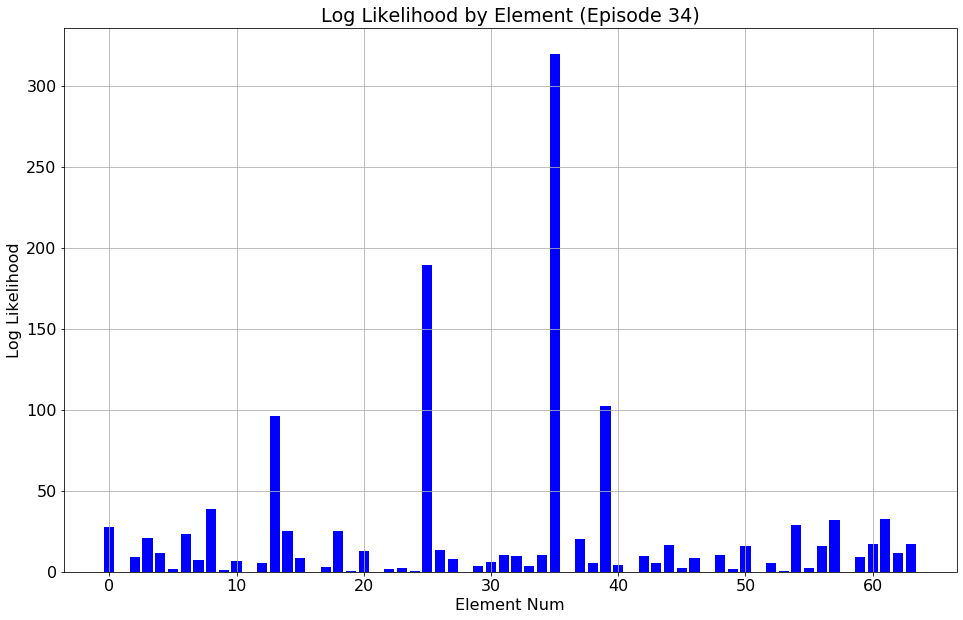

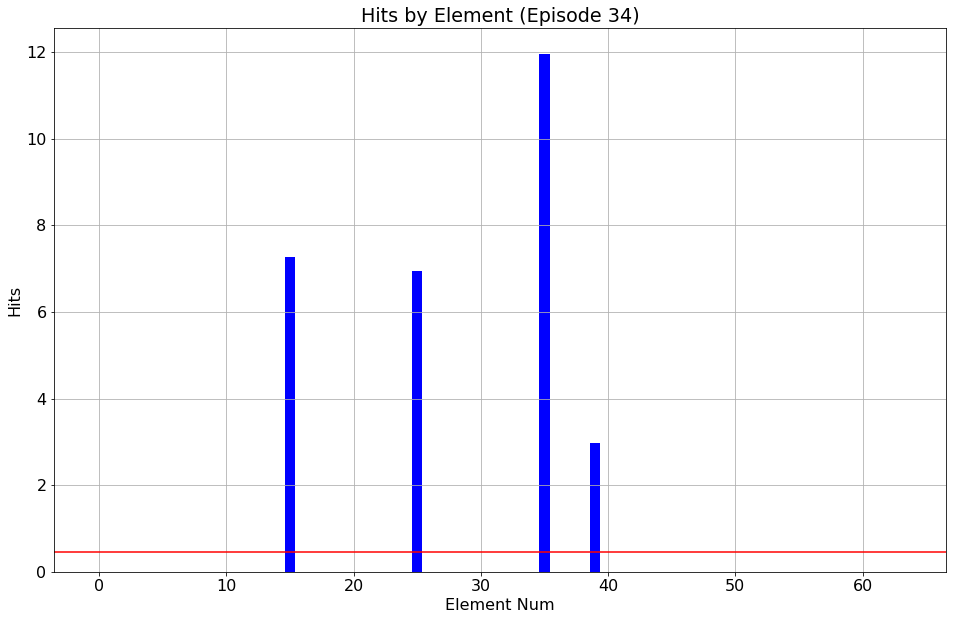

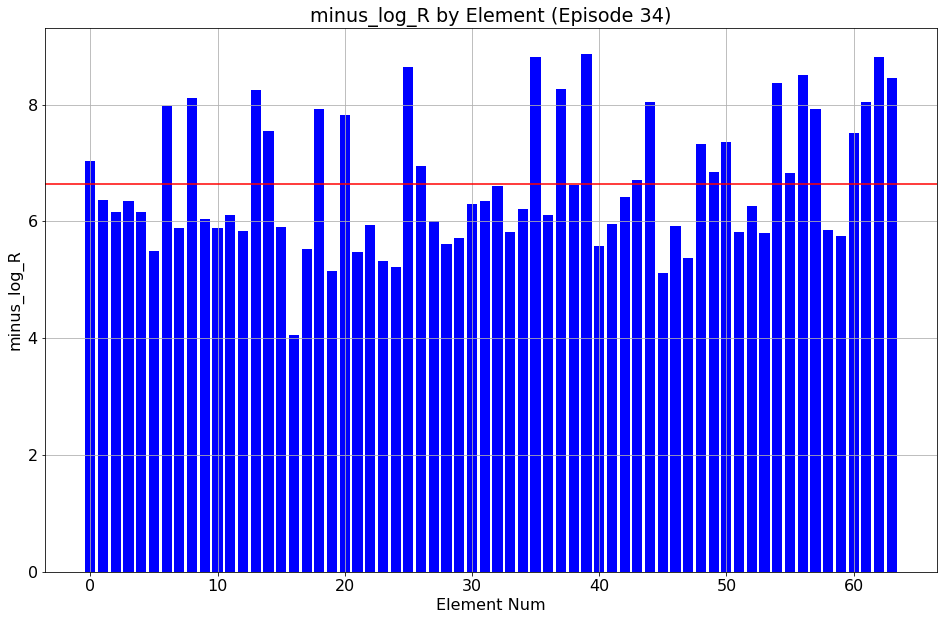

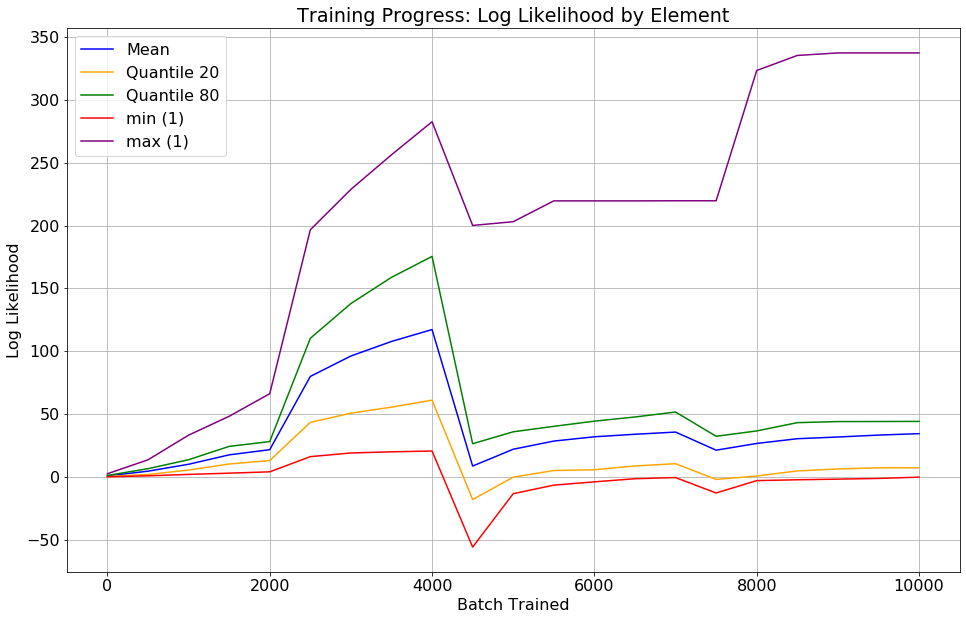

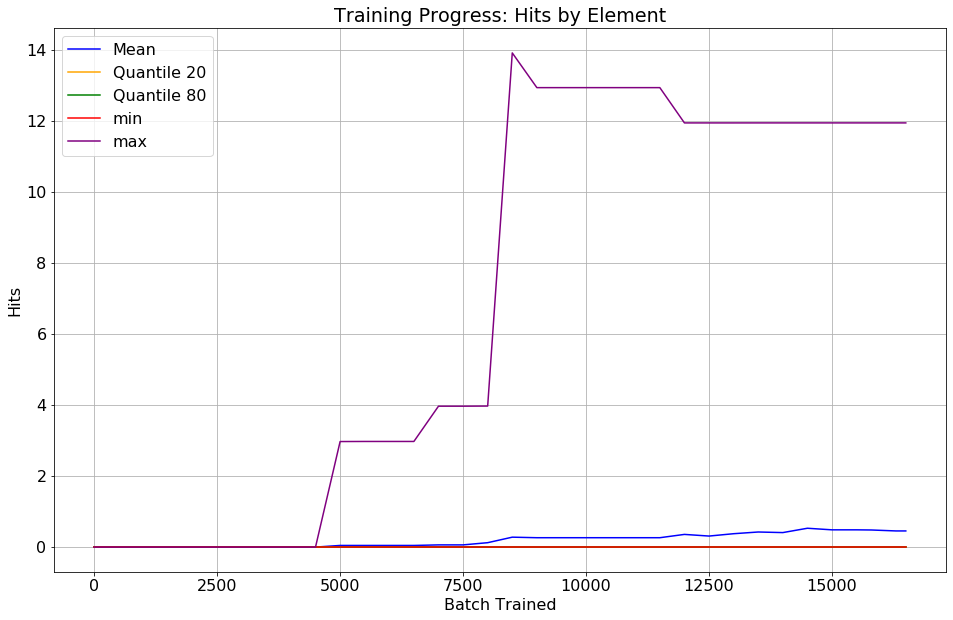

/home/michael/anaconda3/envs/kepler/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1997: RuntimeWarning: invalid value encountered in greater
  cond1 = (0 < q) & (q < 1)
/home/michael/anaconda3/envs/kepler/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1997: RuntimeWarning: invalid value encountered in less
  cond1 = (0 < q) & (q < 1)


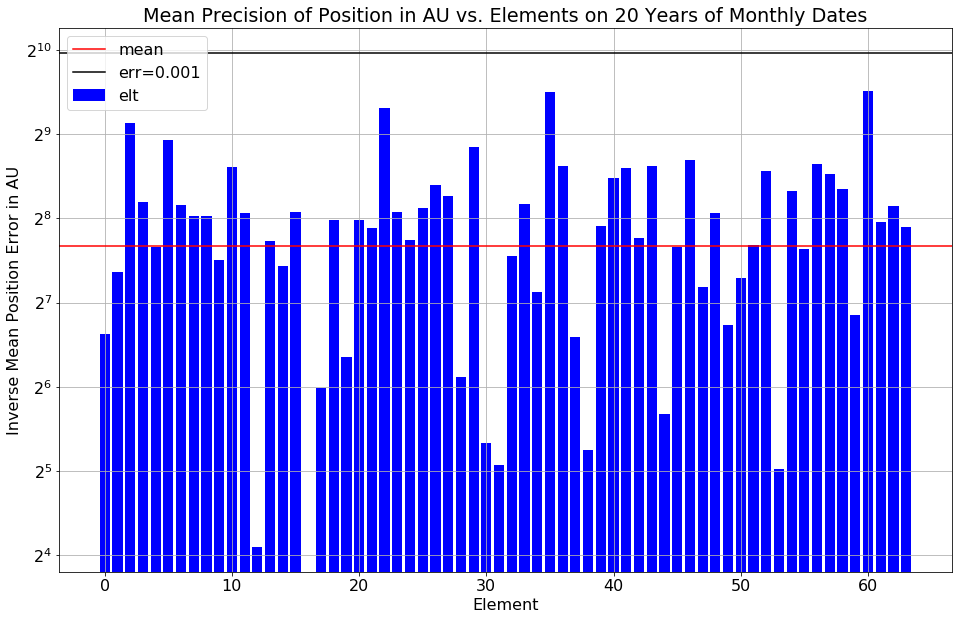

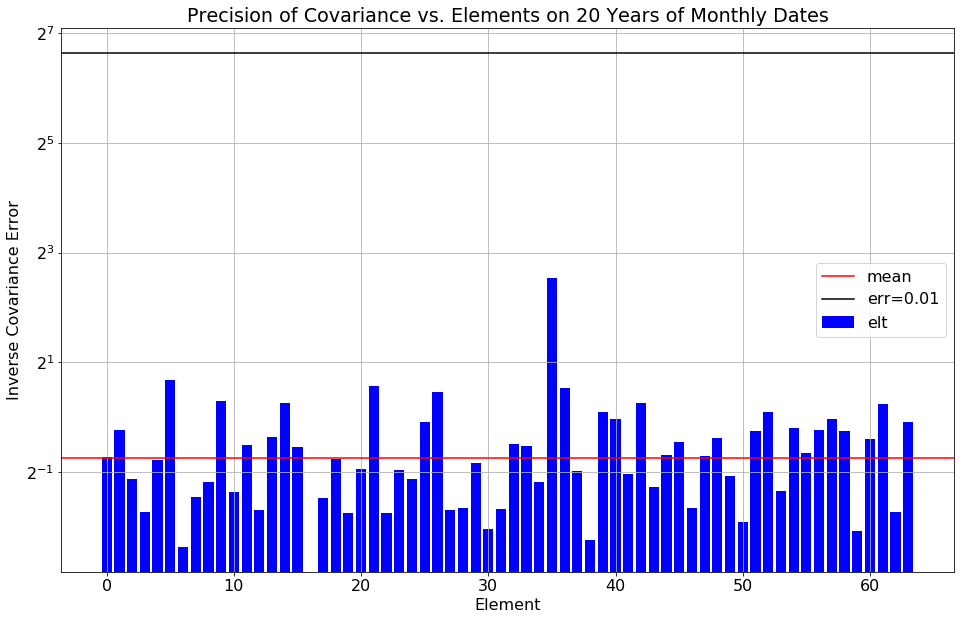

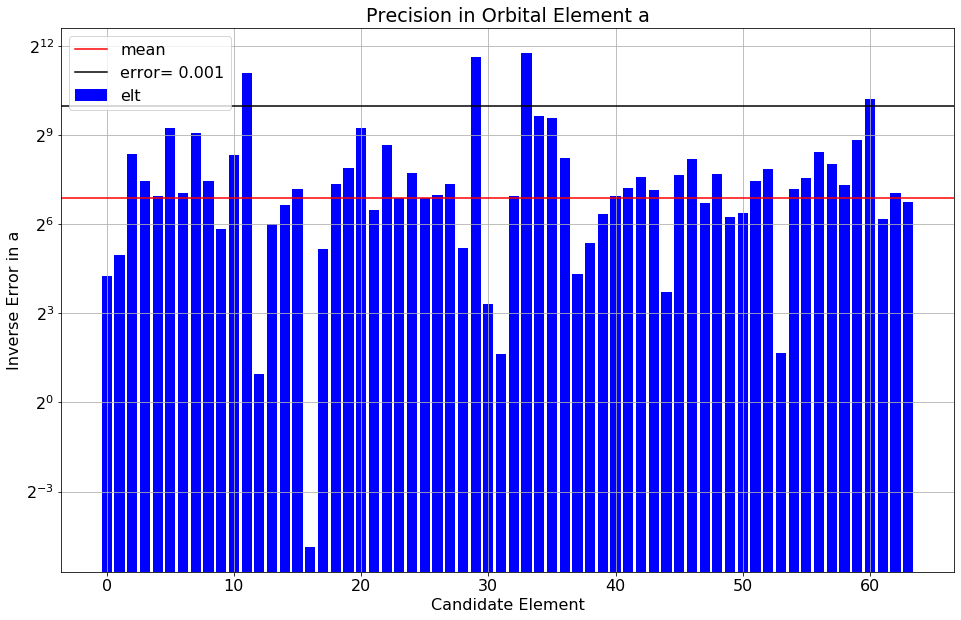

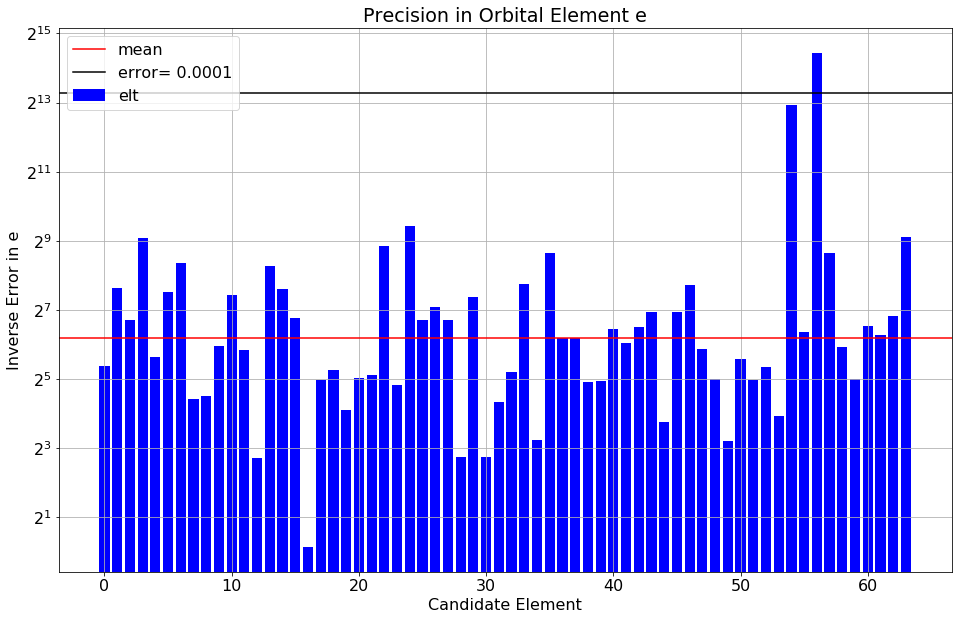

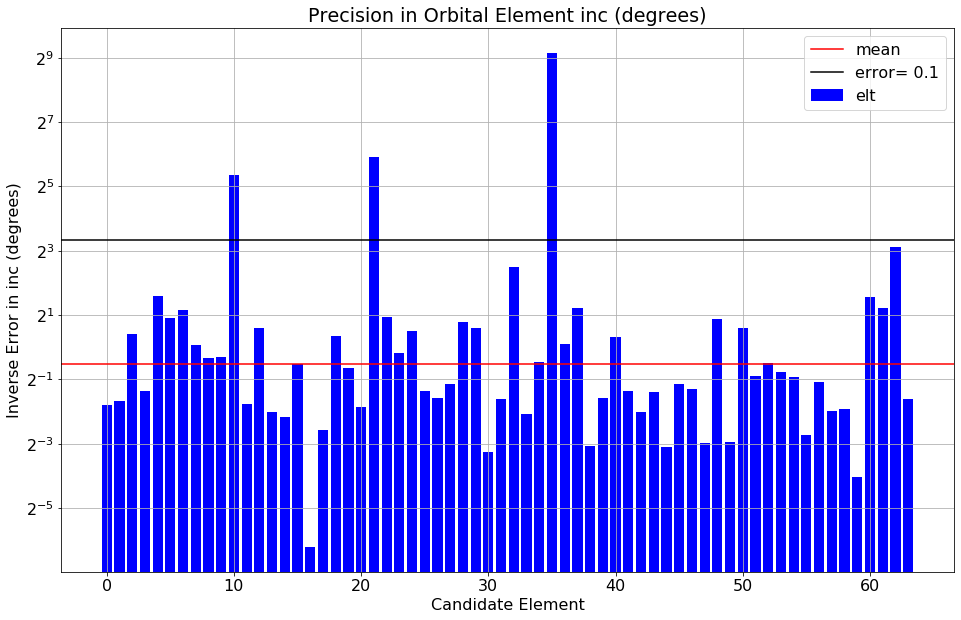

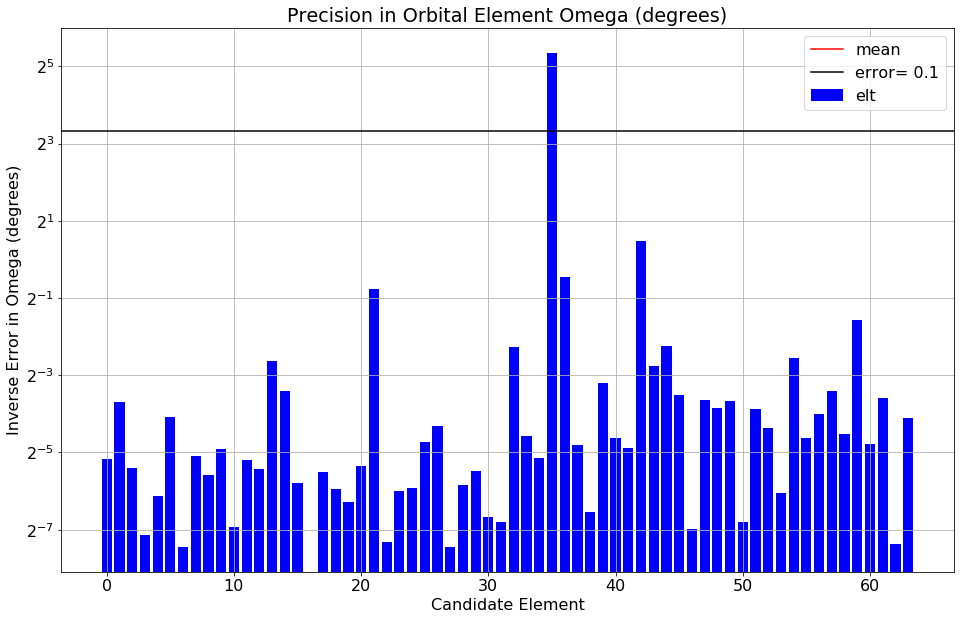

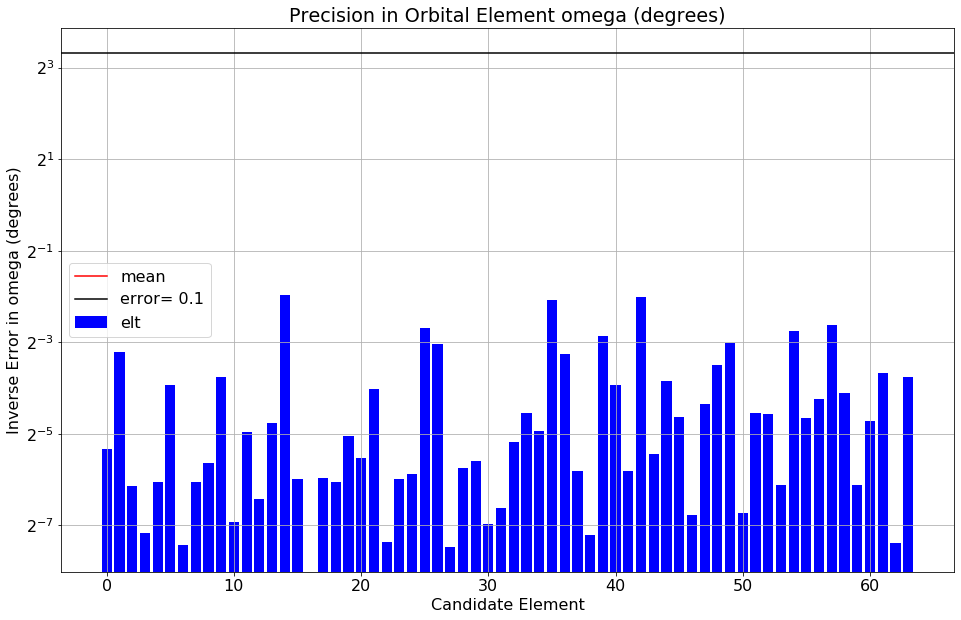

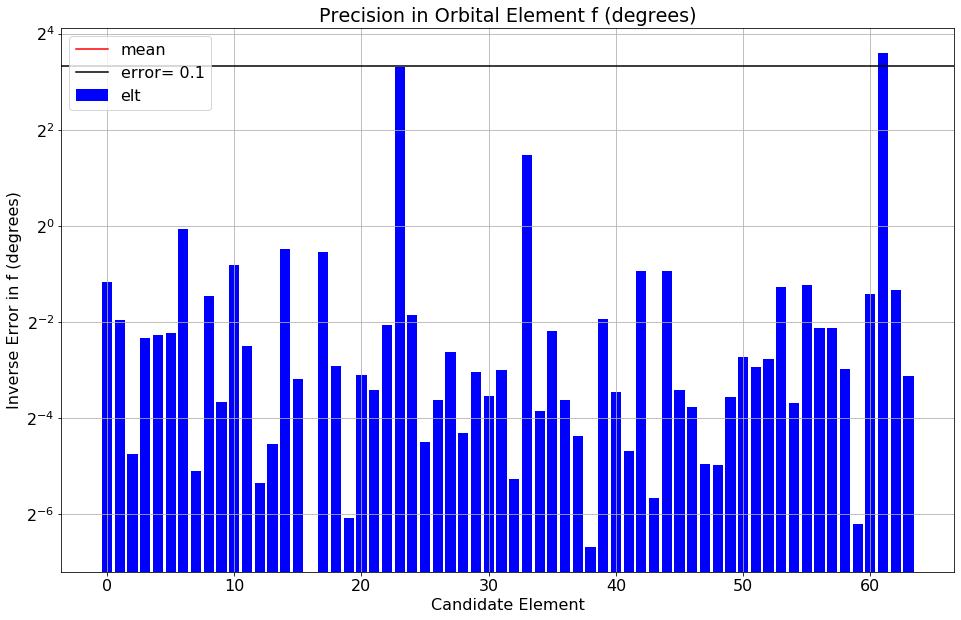

In [25]:
model.sieve(nearest_ast=True)

## Review Results Graphically

In [26]:
# # Bar chart - log likelihood by element
# fig, ax = model.plot_bar('log_like', sorted=False)

In [27]:
# # Bar chart: hits
# fig, ax = model.plot_bar('hits', sorted=False)

In [42]:
# # Bar chart: log likelihood
# fig, ax = model.plot_bar('R_deg', sorted=False)

In [29]:
# # Learning curve: log likelihood
# fig, ax = model.plot_hist('log_like')

In [30]:
# # Learning curve: hits
# fig, ax = model.plot_hist('hits')

## Distance vs. Nearest Asteroid for Fitted Elements

In [31]:
# Find nearest asteroid to fitted elements - search on Cartesian distance
elts_fit, elts_near = model.nearest_ast(search_type='cart')

In [32]:
elts_fit

,element_id,a,e,inc,Omega,omega,f,epoch,num_hits,R,...,thresh_s,thresh_deg,thresh_sec,log_like,hits,H,sigma_mag,nearest_ast_num,nearest_ast_dist,nearest_ast_q_norm
0,0,3.267330,0.166663,0.075811,0.691094,0.934529,-1.302765,58600.0,126.142365,0.000874,...,0.001939,0.111111,399.999939,27.566956,0.0,15.406356,2.496960,83901,0.010147,1.651000
1,1,3.227623,0.202940,0.060258,1.372762,6.205412,-0.495185,58600.0,110.575394,0.001718,...,0.001939,0.111111,399.999939,NaN,0.0,15.901449,2.188013,57426,0.006070,1.176929
2,2,3.150340,0.022566,0.024974,3.674316,0.837310,2.030857,58600.0,292.404755,0.002103,...,0.001939,0.111111,399.999939,9.076056,0.0,15.049524,3.821869,164385,0.001777,2.204406
3,3,2.779342,0.140749,0.023682,1.740427,5.282931,-0.078833,58600.0,230.799438,0.001737,...,0.001939,0.111111,399.999939,20.908661,0.0,15.758951,4.352571,463871,0.003419,3.314108
4,4,3.104838,0.168371,0.087497,0.373700,4.196594,2.370284,58600.0,367.535095,0.002118,...,0.001939,0.111111,399.999939,11.616718,0.0,13.127647,8.000000,228415,0.004949,1.714005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,59,1.849498,0.073093,0.037269,0.700243,3.175738,3.083252,58600.0,318.842224,0.003197,...,0.001939,0.111111,399.999939,9.002015,0.0,18.151249,6.331331,306059,0.008622,4.225320
60,60,2.811945,0.097193,0.059149,5.150900,0.776044,0.870919,58600.0,39.471752,0.000546,...,0.001939,0.111111,399.999939,17.439203,0.0,15.279534,1.103122,327008,0.001370,1.321447
61,61,2.532588,0.119038,0.067598,4.662298,1.934681,-1.057917,58600.0,28.981411,0.000318,...,0.001863,0.106740,384.263885,32.663979,0.0,16.828493,1.278898,298480,0.004029,0.848449
62,62,2.312792,0.185393,0.044575,3.317732,2.228145,-0.616266,58600.0,8.047474,0.000149,...,0.001939,0.111111,399.999939,11.884064,0.0,17.667053,0.979314,224114,0.003517,3.336104


In [33]:
elts_fit.columns

Index(['element_id', 'a', 'e', 'inc', 'Omega', 'omega', 'f', 'epoch',
       'num_hits', 'R', 'R_deg', 'R_sec', 'R_max', 'R_max_deg', 'thresh_s',
       'thresh_deg', 'thresh_sec', 'log_like', 'hits', 'H', 'sigma_mag',
       'nearest_ast_num', 'nearest_ast_dist', 'nearest_ast_q_norm'],
      dtype='object')

In [34]:
# Review asteroids nearest to the fitted elements
# cols = ['element_id', 'nearest_ast_num', 'nearest_ast_name', 'nearest_ast_dist', 'nearest_ast_q_norm']
cols = ['element_id', 'log_like', 'hits', 'R_sec', 'thresh_sec', 'nearest_ast_num', 'nearest_ast_dist', 'nearest_ast_q_norm']

# Summary
is_close_cart = (model.elts_near_ast.nearest_ast_dist < 5.0E-3)
is_close_cov = (model.elts_near_ast.nearest_ast_q_norm < 1.0)
has_hits = (model.elts_fit.hits >= 10)
# is_converged = is_close_cart & is_close_cov
is_converged = has_hits
num_converged = np.sum(is_converged)

# Mean on converged
mean_hits = np.mean(model.elts_fit.hits)
err_cart_mean = np.mean(model.elts_near_ast.nearest_ast_dist[is_converged])
err_cart_geo = np.exp(np.mean(np.log(model.elts_near_ast.nearest_ast_dist[is_converged])))
err_cov_mean = np.mean(model.elts_near_ast.nearest_ast_q_norm[is_converged])

# Report
print(f'Good convergence on {num_converged} asteroids.')
print(f'Mean on converged asteroids:')
print(f'Number of hits         : {mean_hits:5.2f}')
print(f'Mean Distance in AU    : {err_cart_mean:5.2e}')
print(f'GeoMean Distance in AU : {err_cart_geo:5.2e}')
print(f'Covariance norm: {err_cov_mean:5.2e}')

Good convergence on 1 asteroids.
Mean on converged asteroids:
Number of hits         :  0.46
Mean Distance in AU    : 1.38e-03
GeoMean Distance in AU : 1.38e-03
Covariance norm: 1.72e-01


In [35]:
# Review good matches
model.elts_fit[cols][is_converged].sort_values(by=['hits', 'R_sec'], ascending=[False, True])

,element_id,log_like,hits,R_sec,thresh_sec,nearest_ast_num,nearest_ast_dist,nearest_ast_q_norm
35,35,319.585815,11.954579,30.498909,399.999939,49846,0.001384,0.172181


In [36]:
# # Filter for incomplete convergence
# mask = (elts_fit.log_like > 200) & (elts_fit.R_sec >= 60)
# elts_fit[mask]

## Visualize Error vs. Nearest Asteroid

In [37]:
# model.elts_near_ast

In [38]:
model.elts_fit

,element_id,a,e,inc,Omega,omega,f,epoch,num_hits,R,...,thresh_s,thresh_deg,thresh_sec,log_like,hits,H,sigma_mag,nearest_ast_num,nearest_ast_dist,nearest_ast_q_norm
0,0,3.267330,0.166663,0.075811,0.691094,0.934529,-1.302765,58600.0,126.142365,0.000874,...,0.001939,0.111111,399.999939,27.566956,0.0,15.406356,2.496960,83901,0.010147,1.651000
1,1,3.227623,0.202940,0.060258,1.372762,6.205412,-0.495185,58600.0,110.575394,0.001718,...,0.001939,0.111111,399.999939,NaN,0.0,15.901449,2.188013,57426,0.006070,1.176929
2,2,3.150340,0.022566,0.024974,3.674316,0.837310,2.030857,58600.0,292.404755,0.002103,...,0.001939,0.111111,399.999939,9.076056,0.0,15.049524,3.821869,164385,0.001777,2.204406
3,3,2.779342,0.140749,0.023682,1.740427,5.282931,-0.078833,58600.0,230.799438,0.001737,...,0.001939,0.111111,399.999939,20.908661,0.0,15.758951,4.352571,463871,0.003419,3.314108
4,4,3.104838,0.168371,0.087497,0.373700,4.196594,2.370284,58600.0,367.535095,0.002118,...,0.001939,0.111111,399.999939,11.616718,0.0,13.127647,8.000000,228415,0.004949,1.714005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,59,1.849498,0.073093,0.037269,0.700243,3.175738,3.083252,58600.0,318.842224,0.003197,...,0.001939,0.111111,399.999939,9.002015,0.0,18.151249,6.331331,306059,0.008622,4.225320
60,60,2.811945,0.097193,0.059149,5.150900,0.776044,0.870919,58600.0,39.471752,0.000546,...,0.001939,0.111111,399.999939,17.439203,0.0,15.279534,1.103122,327008,0.001370,1.321447
61,61,2.532588,0.119038,0.067598,4.662298,1.934681,-1.057917,58600.0,28.981411,0.000318,...,0.001863,0.106740,384.263885,32.663979,0.0,16.828493,1.278898,298480,0.004029,0.848449
62,62,2.312792,0.185393,0.044575,3.317732,2.228145,-0.616266,58600.0,8.047474,0.000149,...,0.001939,0.111111,399.999939,11.884064,0.0,17.667053,0.979314,224114,0.003517,3.336104


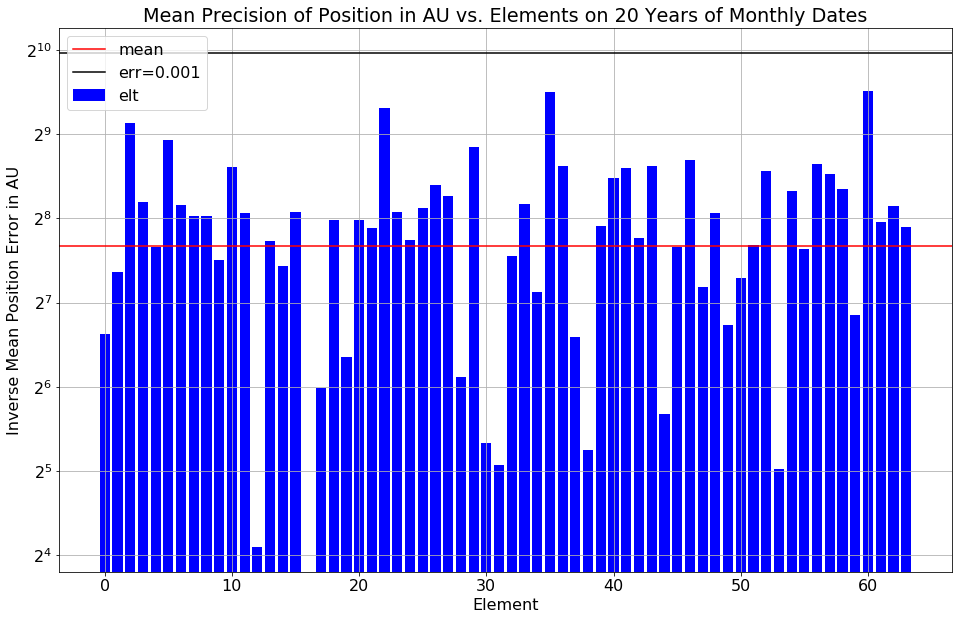

In [39]:
# Plot position error vs. known elements
fig, ax = model.plot_q_error(is_log=True, use_near_ast_dist=True)

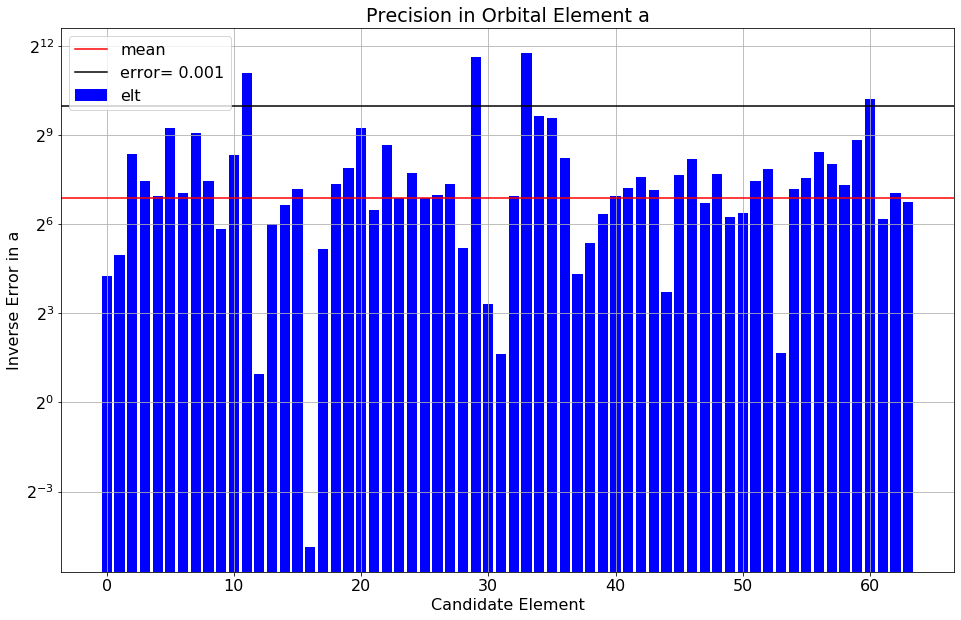

In [40]:
# Plot error in orbital elements
fig, ax = model.plot_elt_error_bar(elt_name='a', is_log=True)

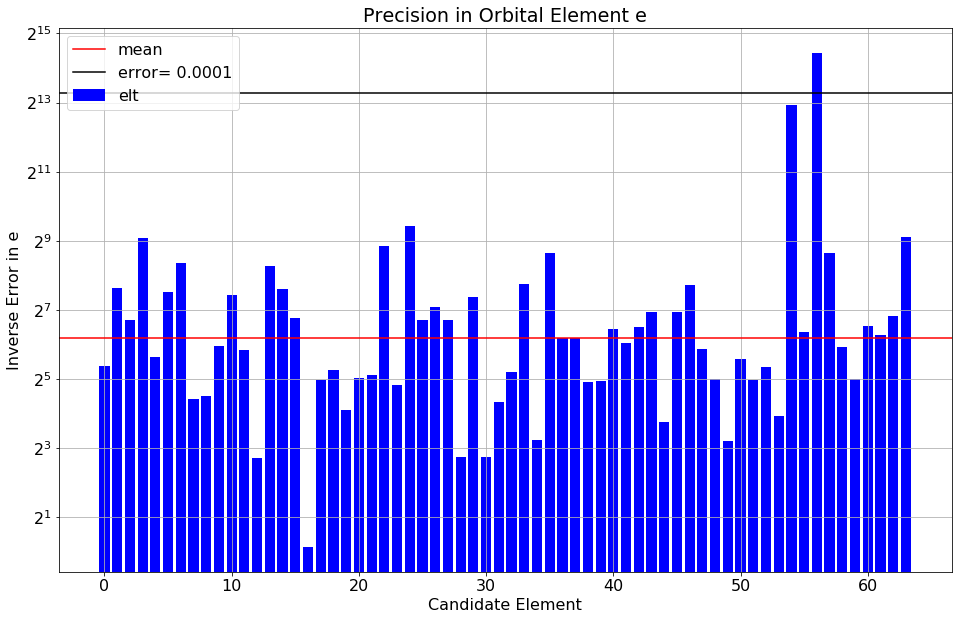

In [41]:
# Plot error in orbital elements
fig, ax = model.plot_elt_error_bar(elt_name='e', is_log=True)